# Using the model's output [probability] to determine the most thrombolysable patient per hospital

In notebook "20_synthetic_patients.ipynb" we explore creating synthetic patients - those that have features that are favourable to use of thrombolysis.

Here are teh criteria for our 'very thrombolysable' synthetic patient:
Onset to arrival = 60 mins
Arrival to scan = 15 mins
Infarction = 1
NIHSS = 15
Prior disability level = 0
Precise onset time = 1
Use of AF anticoagulents = 0

This notebook finds that in our dataset (of the patients that attend the hospitals) examples of a 'very thrombolysable' synthetic patient does not attend each of the 132 hospitals.

Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import machine learning methods
from xgboost import XGBClassifier

# Import shap for shapley values
import shap # `pip install shap` if neeed

# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

from scipy import stats

import os
import pickle

from os.path import exists
import json

/home/kerry/miniconda3/envs/samuel2/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/kerry/miniconda3/envs/samuel2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Json

In [2]:
with open("./output/feature_name_dict.json") as json_file:
    feature_name_dict = json.load(json_file)

## Data location

In [3]:
data_loc = '../data/kfold_5fold/'

## Load data
Just need the five test sets (one from each of the 5-kfold splits), and join them so that have a complete set of the patients.

In [4]:
# Initialise empty lists
test_data = []

# Read in the names of the selected features for the model
number_of_features_to_use = 8
key_features = pd.read_csv('./output/feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
# And add the target feature name: S2Thrombolysis
key_features.append('S2Thrombolysis')

# For each k-fold split
for i in range(5):
    # Read in test set, restrict to chosen features, rename titles, & store
    test = pd.read_csv(data_loc + 'test_{0}.csv'.format(i))
    test = test[key_features]
    test.rename(columns=feature_name_dict, inplace=True)
    test_data.append(test)

## Join all test sets into one dataframe

In [5]:
data = pd.concat(test_data, ignore_index=True)

In [6]:
data.head()

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Stroke team,Use of AF anticoagulents,Onset-to-arrival time,Thrombolysis
0,17.0,1,14.0,1,0,TXHRP7672C,0,186.0,1
1,25.0,1,6.0,1,0,SQGXB9559U,0,71.0,1
2,138.0,1,2.0,1,0,LFPMM4706C,0,67.0,0
3,21.0,0,11.0,1,0,MHMYL4920B,0,86.0,0
4,8.0,1,16.0,1,0,EQZZZ5658G,0,83.0,1


## Also have set of data not restricted by the key features
To explore why the patient did not recieve thrombolysis at their attended hospital, when the features are all 'very thrombolysable'.

In [7]:
# Initialise empty lists
test_data = []

# For each k-fold split
for i in range(5):
    # Read in test set, restrict to chosen features, rename titles, & store
    test = pd.read_csv(data_loc + 'test_{0}.csv'.format(i))
    test_data.append(test)
data_full = pd.concat(test_data, ignore_index=True)

In [8]:
original_number_of_patients = data.shape[0]
print(f"There are {original_number_of_patients} patients in the dataset")

There are 88792 patients in the dataset


Define target values

In [9]:
target_onset_to_arrival = 80#60 #mins
target_arrival_to_scan = 20#15 #mins
target_infarction = 1
target_nihss = 15
target_prior_disability_level = 0
target_precise_onset_time = 1
target_use_of_af_anticoagulents = 0

Filter patients to those that meet the targets

In [10]:
# Filter
mask1 = data["Onset-to-arrival time"] <= target_onset_to_arrival 
mask2 = data["Arrival-to-scan time"] <= target_arrival_to_scan 
mask3 = data["Infarction"] == target_infarction 
mask4 = data["Stroke severity"] == target_nihss 
mask5 = data["Prior disability level"] == target_prior_disability_level
mask6 = data["Precise onset time"] == target_precise_onset_time
mask7 = data["Use of AF anticoagulents"] == target_use_of_af_anticoagulents
mask = mask1 * mask2 * mask3 * mask4 * mask5 * mask6 * mask7

very_thrombolysable_patients = data[mask]

mask1 = data["Onset-to-arrival time"] == target_onset_to_arrival 
mask2 = data["Arrival-to-scan time"] == target_arrival_to_scan 
mask = mask1 * mask2 * mask3 * mask4 * mask5 * mask6 * mask7
very_thrombolysable_patients_exact = data[mask]


In [11]:
n1 = very_thrombolysable_patients.shape[0]
n2 = very_thrombolysable_patients["Stroke team"].nunique()

print (f"The {n1} patients that meet the 'very thrombolysable' criteria "
       f"attend {n2} different stroke teams")

The 134 patients that meet the 'very thrombolysable' criteria attend 72 different stroke teams


In [12]:
n3 = very_thrombolysable_patients_exact["Stroke team"].nunique()
print (f"There are {n3} patients that match the exact 'very thrombolysable' criteria")

There are 1 patients that match the exact 'very thrombolysable' criteria


Two of the criteria are <=. Here are the range of values for the 134 patients that meet the 'very thrombolysable' criteria


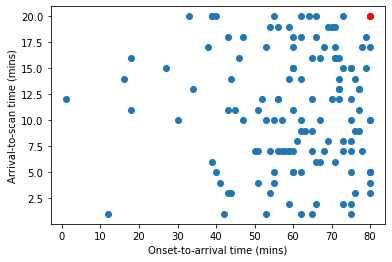

In [13]:
print (f"Two of the criteria are <=. Here are the range of values for the "
       f"{n1} patients that meet the 'very thrombolysable' criteria")

fig, ax = plt.subplots()
#colors = {'North America':'red', 'Europe':'green', 'Asia':'blue', 'Australia':'yellow'}

ax.scatter(very_thrombolysable_patients['Onset-to-arrival time'], 
           very_thrombolysable_patients['Arrival-to-scan time'])
ax.scatter(very_thrombolysable_patients_exact['Onset-to-arrival time'], 
           very_thrombolysable_patients_exact['Arrival-to-scan time'],
           c='red')
      
#           c=frankenstein_patients['Stroke team'].map(colors))
ax.set_xlabel("Onset-to-arrival time (mins)")
ax.set_ylabel("Arrival-to-scan time (mins)")
plt.show()

Of these patients, do any not receive thrombolysis in real world?

In [14]:
mask8 = very_thrombolysable_patients["Thrombolysis"] == 0
very_thrombolysable_patients_not_ivt = very_thrombolysable_patients[mask8]

print (f"{mask8.sum()} 'very thrombolysable' patients do not recieve "
       f"thrombolysis at their attended hosptial")
print()
very_thrombolysable_patients_not_ivt

13 'very thrombolysable' patients do not recieve thrombolysis at their attended hosptial



,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Stroke team,Use of AF anticoagulents,Onset-to-arrival time,Thrombolysis
12620,20.0,1,15.0,1,0,IDHVL2894N,0,66.0,0
13766,20.0,1,15.0,1,0,CQAAX8797Z,0,55.0,0
21039,5.0,1,15.0,1,0,MHMYL4920B,0,80.0,0
26171,12.0,1,15.0,1,0,HZNVT9936G,0,70.0,0
45411,18.0,1,15.0,1,0,ITFRR7678Y,0,66.0,0
49506,5.0,1,15.0,1,0,TFSJP6914B,0,40.0,0
51557,1.0,1,15.0,1,0,XWUBX0795L,0,75.0,0
62195,15.0,1,15.0,1,0,FAJKD7118X,0,75.0,0
63158,17.0,1,15.0,1,0,FAJKD7118X,0,68.0,0
74155,19.0,1,15.0,1,0,FPTBM7594G,0,54.0,0


Take the first patient as an example (of a 'very thrombolysable' patient that didnt recieve thrombolysis in real world)

In [15]:
patient_index = very_thrombolysable_patients_not_ivt.index[0]

Force to print the values of all of the columns for this patient

In [30]:
step = 5
n = int(data_full.shape[1]/step)+1

st = 0
ed = step
for i in range(n):
    print(data_full.iloc[patient_index][st:ed].to_string())
    st = ed
    ed += step

StrokeTeam              IDHVL2894N
S1AgeOnArrival                42.5
S1OnsetToArrival_min          66.0
S2RankinBeforeStroke             0
Loc                              1
LocQuestions    1.0
LocCommands     0.0
BestGaze        0.0
Visual          0.0
FacialPalsy     2.0
MotorArmLeft     0.0
MotorArmRight    4.0
MotorLegLeft     0.0
MotorLegRight    3.0
LimbAtaxia       0.0
Sensory                   2.0
BestLanguage              0.0
Dysarthria                1.0
ExtinctionInattention     1.0
S2NihssArrival           15.0
S2BrainImagingTime_min    20.0
S2Thrombolysis               0
MoreEqual80y_Yes             0
S1Gender_Female              1
S1Ethnicity_Asian            0
S1Ethnicity_Black                      0
S1Ethnicity_Mixed                      0
S1Ethnicity_Other                      0
S1Ethnicity_White                      1
S1OnsetDateType_Stroke during sleep    0
S1OnsetTimeType_Precise           1
S1ArriveByAmbulance_No            0
S1ArriveByAmbulance_Yes           1
S1